# **Classical Music Composer Classification Using Deep Learning**


## **Github Repo**

https://github.com/karthikraghavan/AAI_Composer_Classification.git

___

# **Abstract**

The objective of this project is to leverage deep learning techniques to predict the composer of classical musical scores, focusing on four renowned composers: Bach, Beethoven, Chopin, and Mozart. The dataset, consisting of MIDI files of compositions from these composers, is collected from Kaggle, where each file is weakly labeled based on its folder or filename. The objective is to develop a model capable of classifying these compositions accurately by extracting meaningful musical features and training a deep learning model. The project explores implemenation of three different models - CNN, LSTM and CRNN and reports quantitative results of using different model architectures. The methodology is structured into several phases: Data collection, Data pre-processing, feature engineering, model building & training, model evaluation and creating inferences.

# **Overview**

Our dataset consists of curated MIDI files split into training, validation, and test sets. Each file is parsed into a fixed-size pianoroll, normalized, and label-encoded. Augmentation techniques such as pitch shifting, tiime shift and randomizing velocity are applied to increase data diversity. The models are implemented using TensorFlow/Keras, with training monitored through accuracy and loss metrics. Evaluation includes classification reports, confusion matrices, and test-set predictions.

# **Methodology**

**Data Collection** – Gathering MIDI files from verified sources for Bach, Beethoven, Chopin, and Mozart.  
**Preprocessing** – Converting MIDI to pianoroll format, normalizing values, and label encoding.  
**Data Augmentation** – Pitch shifting, note dropout, and tempo variation to expand the dataset.  
**Model Architectures** – Implementing three models:    
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**CNN** for spatial feature extraction from pianoroll images.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**CRNN** combining convolutional and recurrent layers for temporal-spatial features.  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**LSTM** for sequential temporal modeling.  
**Training** – Using early stopping, dropout layers, batch normalization, and class weighting to improve generalization.  
**Model Optimization** – Hyperparameter tuning, learning rate scheduling, and architecture adjustments to improve accuracy and reduce overfitting.  
**Evaluation** – Accuracy, precision, recall, F1-score, and confusion matrices for each model.  


___

# 1. Data Collection and Libraries

In [1]:
import os, random, collections
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict
from copy import deepcopy
import uuid
import shutil

# %pip install miditoolkit pretty_midi 
import tensorflow as tf
import pretty_midi
import miditoolkit
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, Model, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, GlobalMaxPooling2D, Dense
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Reshape, GRU, Dense, Dropout, Flatten, concatenate, LayerNormalization
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint



Since there are different versions of dataset, the below code standardizes and prepares the training, validation, and test datasets for each composer, ensuring consistency across all model variations

In [2]:
SOURCE_DIR = 'archive/midiclassics' # original dataset
DEST_ROOT = 'archive/composers' # dataset split into train, dev and test
SPLIT_RATIOS = (0.8, 0.1, 0.1) # train, dev, test split ratios
NUM_CLASSES = 10

# Define target composers
target_composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# create folders
splits = ['train', 'dev', 'test']

# create destination folder for model training
if not os.path.exists(DEST_ROOT):
    os.makedirs(DEST_ROOT)
    for split in splits:
        os.makedirs(os.path.join(DEST_ROOT, split))

# Go through each composer from original dataset
for composer in os.listdir(SOURCE_DIR):
    # select only the target composers required for this project
    if composer not in target_composers:
        continue
    
    composer_path = os.path.join(SOURCE_DIR, composer) # source directory composer path
    
    # ignore the individual files
    if not os.path.isdir(composer_path):
        continue
    
    # split into train test and validation
    midi_files = [f for f in os.listdir(composer_path) if f.endswith('mid')]
    total_files = len(midi_files)
    train_files = int(total_files * SPLIT_RATIOS[0])
    dev_files = int(total_files * SPLIT_RATIOS[1])
    test_files = train_files - dev_files

    split_files = {
        'train' : midi_files[:train_files],
        'dev' : midi_files[train_files:train_files + dev_files],
        'test' : midi_files[train_files+dev_files:]
    }

    # copy the files to respective folders
    for split, file_list in split_files.items():
        split_dir = os.path.join(DEST_ROOT, split, composer)
        os.makedirs(split_dir, exist_ok=True)
        
        # copy the files from source to destination directory
        for fname in file_list:
            src = os.path.join(composer_path, fname)
            dest = os.path.join(split_dir, fname)
            shutil.copy2(src, dest)

___

# 2. Data Loading & Exploration

**Data Augmentation**

In [3]:
# Initialization parameters
DEV = 'archive/composers/dev'
TEST = 'archive/composers/test'
TRAIN = 'archive/composers/train'

PITCH_SHIFT_RANGE = list(range(-5, 6))  # -5..+5 semitones
DROP_NOTE_PROB = 0.3                    # 30% chance to drop a note
TARGET_SEGMENTS = 100                   # target number of 30s segments per composer
SEGMENT_SEC = 30.0                      # used by segment extraction helpers
NUM_CLASSES = 4                         # Total number of target classes
MAX_SEQUENCE_LENGTH = 500               # for LSTM input

**Data Augmentation**

In [4]:
# Loads the dataset from TRAIN path
def load_midi_files(dataset_path):
    durations = []
    composer_files = defaultdict(list)
    # Loop through the list of composers and prepare the dataframe
    for composer in os.listdir(dataset_path):
        composer_path = os.path.join(dataset_path, composer)
        if os.path.isdir(composer_path):
            for file in os.listdir(composer_path):
                if file.endswith(('.mid', '.midi')):
                    file_path = os.path.join(dataset_path, composer, file)
                    composer_files[composer].append(file_path)
                    # Load the MIDI file into a PrettyMIDI object for parsing and processing
                    try:
                        # 
                        midi = pretty_midi.PrettyMIDI(file_path)
                        # create a list with composers, filepath and duration of each music file
                        durations.append({
                            'Composer': composer,
                            'File': os.path.basename(file_path),
                            'Duration': midi.get_end_time()
                        })
                    except Exception as e:
                        print(f"Error reading {file}: {e}")

    print(f"Files processed: {len(durations)}")
    return composer_files, durations

# load files into a dictionary
composer_files, durations = load_midi_files(TRAIN)
durations_df = pd.DataFrame(durations) # data frame of composers, file path and duration of each music file

# Add Segment_Count column (number of 30-second segments per file)
durations_df['Segment_Count'] = (durations_df['Duration'] // 30).astype(int)

# Group by composer and sum the segment counts
total_segments_per_composer = durations_df.groupby('Composer')['Segment_Count'].sum().reset_index()

# Sort composers by total segment count descending (optional but recommended)
total_segments_per_composer = total_segments_per_composer.sort_values(by='Segment_Count', ascending=False)

/opt/anaconda3/envs/env_tf/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Files processed: 383


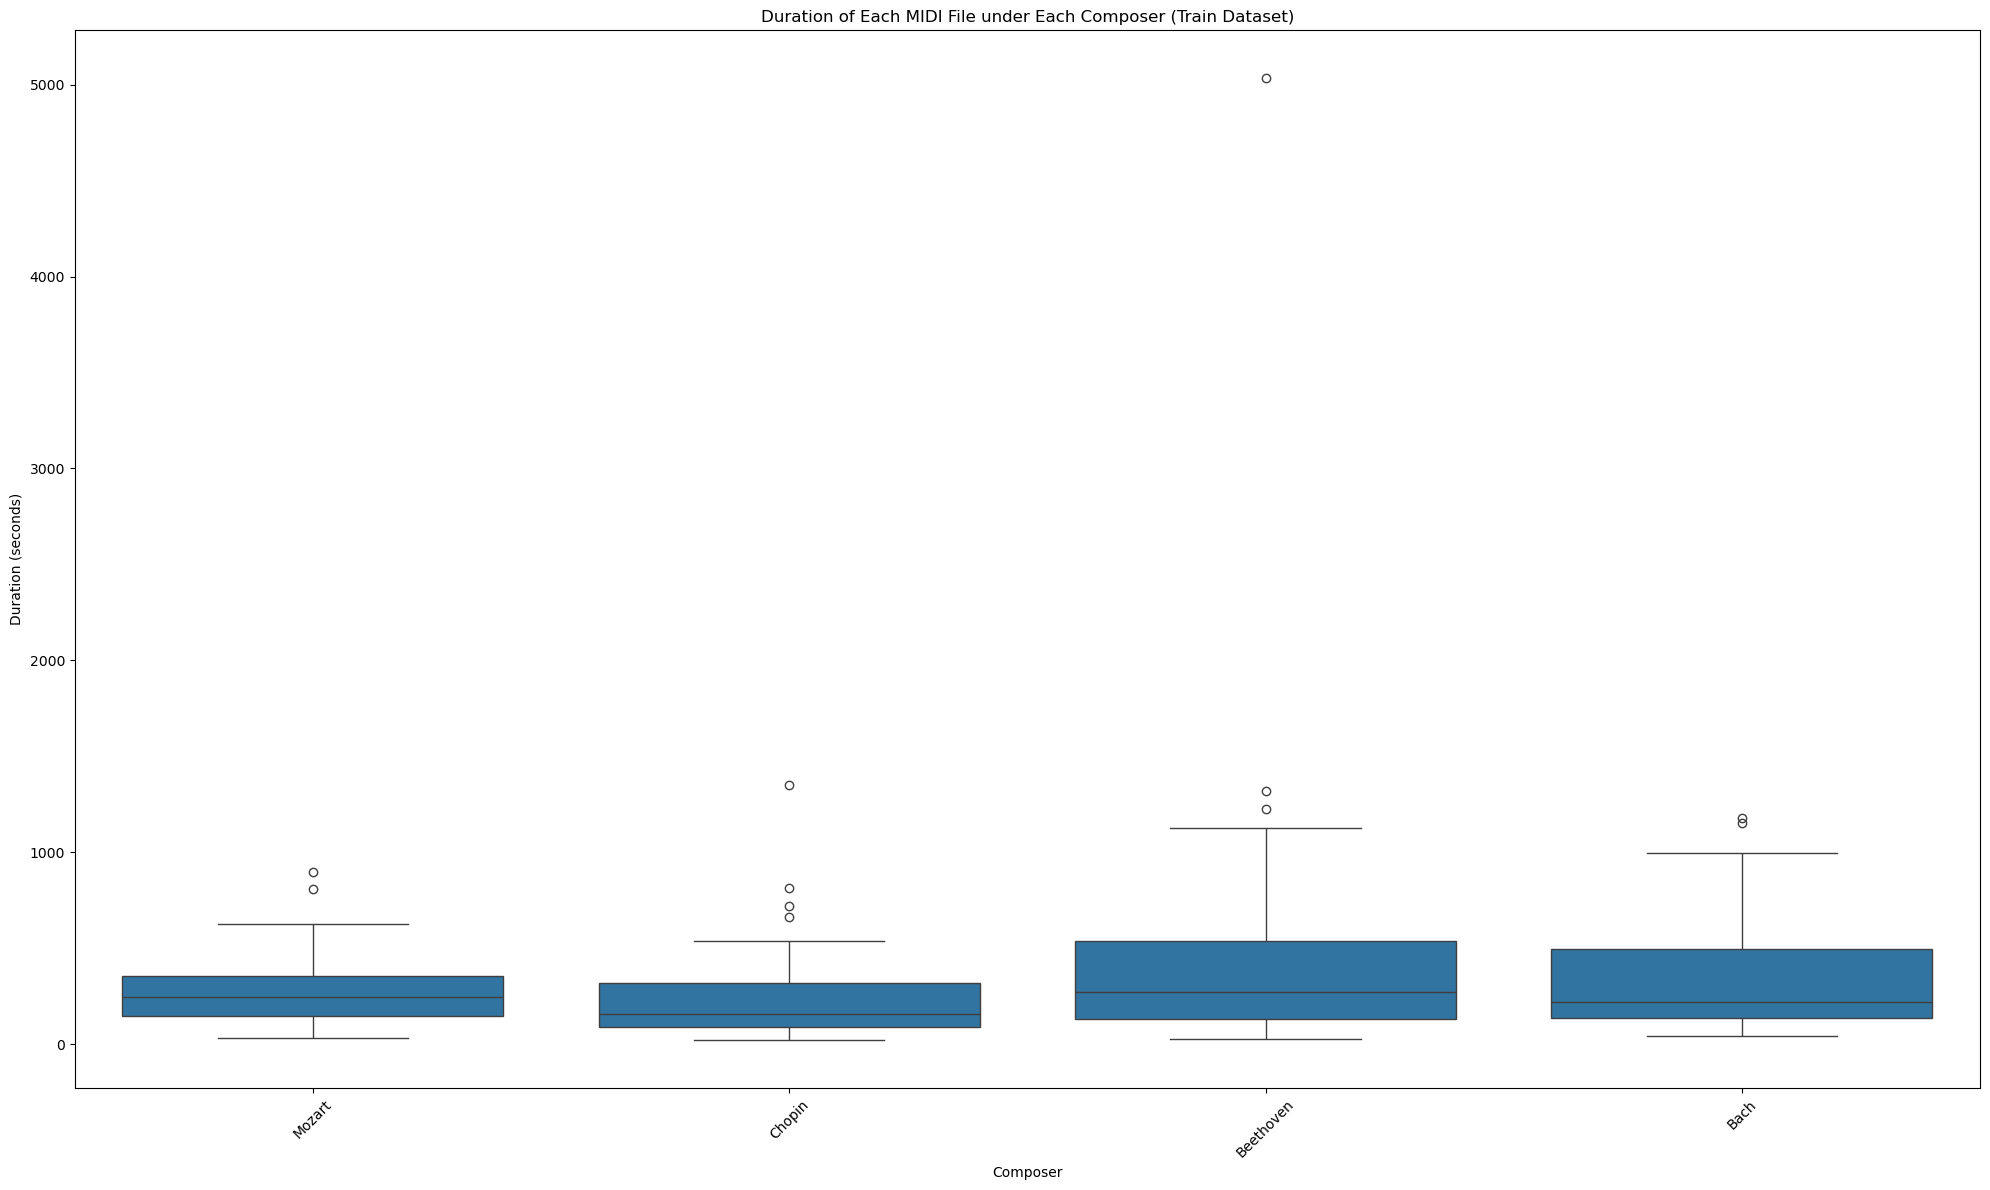

In [5]:
# Box plot of duration of each midi file
plt.figure(figsize=(20, 12))
sns.boxplot(data=durations_df, x='Composer', y='Duration')
plt.title('Duration of Each MIDI File under Each Composer (Train Dataset)')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This boxplot shows the distribution of MIDI file durations (in seconds) for each composer in your training dataset.
- All composers (Mozart, Chopin, Beethoven, Bach) have median durations roughly between 150–250 seconds (2.5–4 minutes)
- Beethoven and Bach have a noticeably wider spread in duration compared to Mozart and Chopin, suggesting greater variation in piece length
- All composers have some outliers — particularly:
    - Beethoven has one extreme outlier at ~5,000 seconds (~83 minutes).
    - Bach and Mozart have outliers above 900 seconds (~15 minutes).
    - Chopin has a moderate outlier around 1,300 seconds (~21 minutes).

The below plot displays the number of segments under each composer. It also displays the class imbalance between various composers

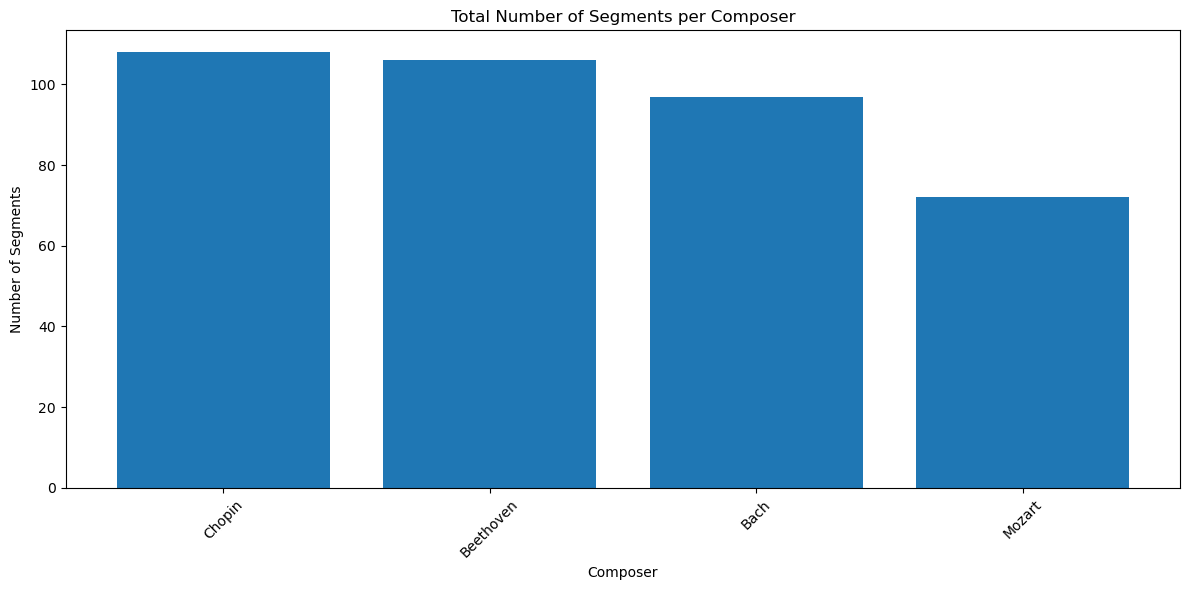

In [6]:
# Count how many 30-second segment files exist per composer folder and plot the results.
def plot_segment_counts_from_folder(balanced_dir):
    composer_counts = []

    for composer in os.listdir(balanced_dir):
        comp_path = os.path.join(balanced_dir, composer)
        if os.path.isdir(comp_path):
            num_segments = len([f for f in os.listdir(comp_path) if f.endswith('.mid')])
            composer_counts.append({'Composer': composer, 'Segment_Count': num_segments})

    counts_df = pd.DataFrame(composer_counts).sort_values(by='Segment_Count', ascending=False)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.bar(counts_df['Composer'], counts_df['Segment_Count'])
    plt.title('Total Number of Segments per Composer')
    plt.xlabel('Composer')
    plt.ylabel('Number of Segments')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return counts_df

counts_df = plot_segment_counts_from_folder(TRAIN)


Beethovan has 1,380 segments — the highest among all composers. This is more than double the number for Mozart.

The largest class (Beethoven) has ~2.2× more samples than the smallest class (Mozart). Such imbalance can bias the model toward predicting Beethoven more often.

# 3. Feature Extraction & Augmentation

Piano roll and sequence roll (or note sequence) are two different ways of representing the same musical information, but optimized for different types of models and tasks.

Sequence roll extracts a sequence of notes from a MIDI file, including features: [pitch, duration, velocity, program, time signature, tempo, onset time].  
Piano roll extracts a fixed-size piano roll representation from a MIDI file.

- Each row = pitch (0–127), each column = time step.
- Pads or truncates to `shape[1]` time steps.
- Transposes output to (time_steps, pitches) format.

In [7]:
PIANO_ROLL_SHAPE = (128, 128)  # Fixed piano roll shape: 128 pitches × 128 time steps

# Extract note sequences from a MIDI file
def extract_note_sequence(midi_file, max_len=MAX_SEQUENCE_LENGTH):
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
        notes = []

        # Estimate tempo; fallback to 120 BPM if unavailable
        tempo = pm.estimate_tempo() if pm.estimate_tempo() else 120  # Default to 120 BPM if not found

        # Extract time signature; default to 4/4 if unavailable
        time_signature = pm.time_signature_changes[0].numerator / pm.time_signature_changes[0].denominator if pm.time_signature_changes else 4/4  # Default to 4/4
        
        # Iterate through all non-drum instruments
        for instrument in pm.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    onset_time = note.start
                    notes.append((
                        note.pitch,                 # MIDI pitch (0–127)
                        note.end - note.start,      # Duration in seconds 
                        note.velocity,              # Velocity (0–127)
                        instrument.program,         # Instrument program number 
                        time_signature,             # Time signature ratio
                        tempo,                      # Tempo (BPM)
                        onset_time                  # Note start time in seconds
                    ))
        
        # Sort notes by onset time and keep only first `max_len`
        notes = sorted(notes, key=lambda x: x[6])[:max_len]  # Sort by onset_time

        # Pad with zeros if sequence shorter than `max_len`
        if len(notes) < max_len:
            notes += [(0, 0, 0, 0, time_signature, tempo, 0)] * (max_len - len(notes))
        return np.array(notes)
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return np.zeros((max_len, 7))  # Adjusted for 7 features

# Extract piano roll (fixed size)
def extract_piano_roll(midi_file, shape=PIANO_ROLL_SHAPE):
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)

        # Get raw piano roll (shape: pitches × time_steps)
        piano_roll = pm.get_piano_roll(fs=10)

        # Pad with zeros if fewer time steps than target
        if piano_roll.shape[1] < shape[1]:
            pad_width = shape[1] - piano_roll.shape[1]
            piano_roll = np.pad(piano_roll, ((0, 0), (0, pad_width)), mode='constant')
        
        # Truncate if more time steps than target
        elif piano_roll.shape[1] > shape[1]:
            piano_roll = piano_roll[:, :shape[1]]
        
        # Transpose to (time_steps, pitches)
        return piano_roll.T  # transpose to (time_steps, pitches)
    except Exception as e:
        print(f"Error processing {midi_file}: {e}")
        return np.zeros((shape[1], shape[0]))

Normalize and Prepare the dataset. Normalization for piano roll and note sequence features to a fixed numerical range for better model training stability.

The dataset is prepared by loading the MIDI files, extracting the sequence and piano roll features and reshaping the inputs, and encodes target labels. This is specifically required for CRNN architecture.

In [8]:
def encode_target(target, num_classes):
    le = LabelEncoder()
    target = le.fit_transform(target)
    target_onehot = to_categorical(target, num_classes)
    return target_onehot

# Normalize sequence and piano rolls
def normalize(X_roll):
    # Normalize piano roll velocities to [0, 1]
    X_roll /= 127.0
    return X_roll

# Load all MIDI files in the dataset and prepare features and labels
def prepare_data(dataset_path, num_classes, data_type):
    X_seq, X_roll, y = [], [], []
    composer_files = defaultdict(list)

    # Traverse through each composer's folder
    for composer in os.listdir(dataset_path):
        composer_path = os.path.join(dataset_path, composer)
        if os.path.isdir(composer_path):
            for file in os.listdir(composer_path):
                # Process only MIDI files
                if file.endswith('.mid') or file.endswith('.midi'):
                    file_path = os.path.join(dataset_path, composer, file)

                    # Extract note sequence and piano roll representations
                    seq = extract_note_sequence(file_path)
                    roll = extract_piano_roll(file_path)
                    X_seq.append(seq)
                    X_roll.append(roll)
                    y.append(composer)

    # Convert lists to NumPy arrays for model input
    X_seq, X_roll = np.array(X_seq), np.array(X_roll)
    X_roll = X_roll.reshape((X_roll.shape[0], 128, 128, 1))

    # Encode composer names into one-hot encoded target vectors
    y_enc = encode_target(y, num_classes)

    # Display data shapes for verification
    print(f"{data_type} Roll:", X_roll.shape)
    print(f"{data_type} Seq:", X_seq.shape)
    print(f"{data_type} Target:", y_enc.shape)

    return X_seq, X_roll, y_enc

### Data Augmentation

This data augmentation pipeline enhances a MIDI dataset for composer classification by applying a variety of transformations to increase diversity and balance class representation. It includes pitch shifting (transposing notes up or down by a few semitones while preserving pitch bounds), note dropping (randomly removing a small proportion of notes), time stretching (slightly speeding up or slowing down playback), and velocity randomization (adjusting note loudness within a set range). 

These augmentations can be applied individually alongside a segmentation process. The system samples segments uniformly from each composer’s works, prioritizing less frequently used source files for diversity, and generates enough augmented segments to meet a target per class. This approach both increases training data volume and mitigates class imbalance, leading to a more robust and generalizable model.

In [9]:
# Shifts the pitch of all notes in a MIDI file by a specified number of semitones
def pitch_shift_midi(midi_data, semitone_shift):
    for inst in midi_data.instruments:
        if inst.is_drum:
            continue
        for n in inst.notes:
            n.pitch = int(min(127, max(0, n.pitch + semitone_shift)))
    return midi_data


# Augmentation functions
def drop_notes_midi(midi_data, drop_prob=0.1):
    for instrument in midi_data.instruments:
        instrument.notes = [note for note in instrument.notes if random.random() > drop_prob]
    return midi_data

# Stretches or compresses the timing of notes in a MIDI file by a scaling factor
def time_stretch_midi(midi_data, stretch_factor):
    end = midi_data.get_end_time()
    if end <= 0: 
        return midi_data
    midi_data.adjust_times([0, end], [0, end * stretch_factor])
    return midi_data

# Randomly adjusts the velocity (loudness) of notes in a MIDI file within a given range.
def randomize_velocity(midi_data, variation=20):
    for inst in midi_data.instruments:
        for n in inst.notes:
            n.velocity = int(max(1, min(127, n.velocity + random.randint(-variation, variation))))
    return midi_data


# list of augmentations to apply across the dataset
AUG_METHODS = ['pitch_shift', 'time_stretch', 'velocity', 'drop_note', 'combined']

# method to apply augmentations
def apply_augmentation(midi_data):
    strategy = random.choice(AUG_METHODS)
    if strategy == 'pitch_shift':
        return pitch_shift_midi(midi_data, semitone_shift=random.choice([-2, -1, 1, 2]))
    elif strategy == 'drop_note':
        return drop_notes_midi(midi_data, drop_prob=0.15)
    elif strategy == 'time_stretch':
        return time_stretch_midi(midi_data, stretch_factor=random.uniform(0.9, 1.1))
    elif strategy == 'velocity':
        return randomize_velocity(midi_data)
    elif strategy == 'combined':
        midi_data = pitch_shift_midi(midi_data, random.choice([-2, 2]))
        midi_data = drop_notes_midi(midi_data, 0.1)
        midi_data = randomize_velocity(midi_data)
        return midi_data
    return midi_data

# Copy notes overlapping [start_time, start_time+seg_len), trim to window, and shift so segment starts at t=0.
# Keeps tempo/time-signature changes that fall inside the window (approx by copying whole metadata then trimming).
def extract_30s_segment(src_midi: pretty_midi.PrettyMIDI, start_time: float, seg_len: float = SEGMENT_SEC) -> pretty_midi.PrettyMIDI:
    end_time = start_time + seg_len
    seg = pretty_midi.PrettyMIDI(initial_tempo=120)

    # Copy metadata (instruments & drums)
    for inst in src_midi.instruments:
        new_inst = pretty_midi.Instrument(program=inst.program, is_drum=inst.is_drum, name=inst.name)
        for n in inst.notes:
            # keep notes that intersect the window
            if n.end <= start_time or n.start >= end_time:
                continue
            # trim to window and shift to start at 0
            s = max(n.start, start_time) - start_time
            e = min(n.end, end_time) - start_time
            if e > s:
                new_inst.notes.append(pretty_midi.Note(velocity=n.velocity, pitch=n.pitch, start=s, end=e))
        if new_inst.notes:
            seg.instruments.append(new_inst)

    return seg

# Create exactly `target_per_class[composer]` 30s segments by sampling windows from source files and augmenting them. Writes segments as standalone MIDI files.
def balance_by_segments(composer_to_files, target_per_class, out_dir):

    os.makedirs(out_dir, exist_ok=True)
    created = []

    # Track how often a source file is reused to keep diversity
    use_count = collections.Counter()

    for composer, files in tqdm(composer_to_files.items(), desc=f"Augmenting dataset"):
        target = int(target_per_class[composer])
        made = 0

        # Preload file durations to sample windows uniformly
        file_infos = []
        for f in files:
            try:
                m = pretty_midi.PrettyMIDI(f)
                dur = m.get_end_time()
                if dur >= 1.0:
                    file_infos.append((f, dur))
            except Exception:
                continue

        if not file_infos:
            print(f"[WARN] No valid files for {composer}; skipping.")
            continue

        while made < target:
            # sample a source file, bias toward less-used for diversity
            file_infos.sort(key=lambda x: use_count[x[0]])
            src_path, dur = random.choice(file_infos[:max(1, len(file_infos)//2)])

            # if file is shorter than SEGMENT_SEC, pad by looping start time at 0
            if dur <= SEGMENT_SEC:
                start_t = 0.0
            else:
                start_t = random.uniform(0.0, max(0.0, dur - SEGMENT_SEC))

            try:
                midi_src = pretty_midi.PrettyMIDI(src_path)
                seg = extract_30s_segment(midi_src, start_t, SEGMENT_SEC)
                if not any(inst.notes for inst in seg.instruments):
                    # empty slice (e.g., silent region) → resample
                    continue

                seg = apply_augmentation(seg)
                comp_dir = os.path.join(out_dir, composer)
                os.makedirs(comp_dir, exist_ok=True)
                fname = f"{composer}_seg_{made:05d}_{random.randint(1000,9999)}.mid"
                fpath = os.path.join(comp_dir, fname)
                seg.write(fpath)

                created.append((fpath, composer))
                use_count[src_path] += 1
                made += 1

            except Exception as e:
                # try another sample if something went wrong
                print(f"Error processing: {e}")
                continue

        print(f"[OK] {composer}: created {made} segments")

    return created

Augment the mid files across each composer such that all composers have equal number of segments. The augmented files will be stored in the same folder.

Augmenting dataset:   0%|          | 0/4 [00:00<?, ?it/s]/opt/anaconda3/envs/env_tf/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
Augmenting dataset:  25%|██▌       | 1/4 [01:05<03:17, 65.74s/it]

[OK] Mozart: created 1381 segments


Augmenting dataset:  50%|█████     | 2/4 [01:55<01:52, 56.16s/it]

[OK] Chopin: created 1381 segments


Augmenting dataset:  75%|███████▌  | 3/4 [03:35<01:16, 76.26s/it]

[OK] Beethoven: created 1381 segments


Augmenting dataset: 100%|██████████| 4/4 [04:21<00:00, 65.46s/it]

[OK] Bach: created 1381 segments


Files processed: 5907


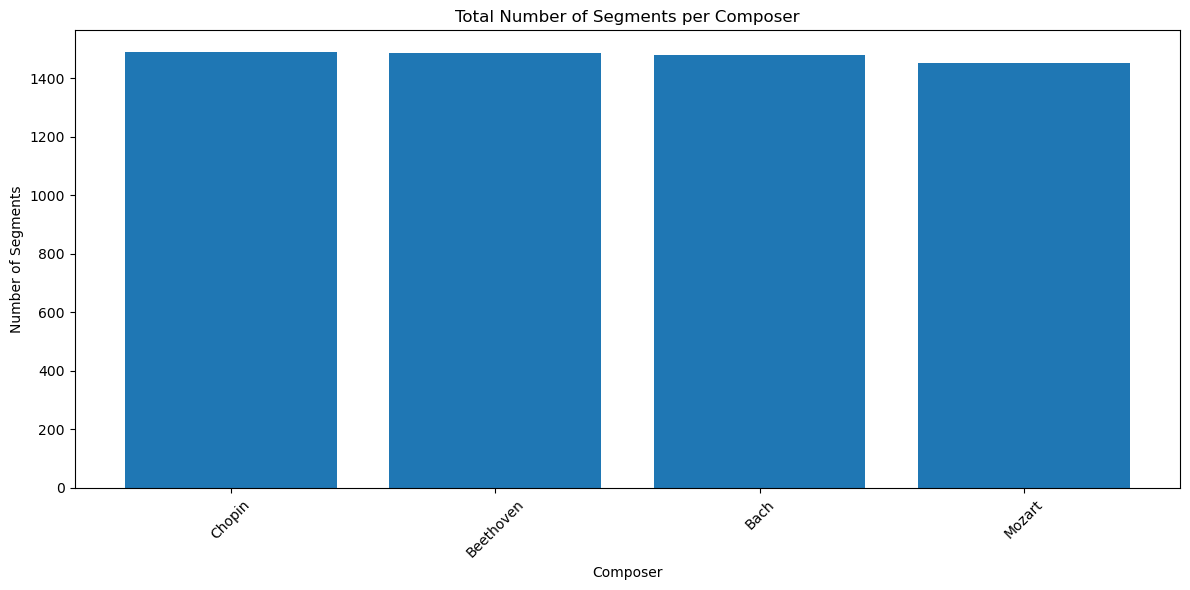

In [10]:
# Decide exact targets per class 
max_segments = total_segments_per_composer['Segment_Count'].max()
target_per_class = {
    row['Composer']: max_segments
    for _, row in total_segments_per_composer.iterrows()
}
# Generate segments directly 
out_dir = TRAIN  # write segments to this directory
created = balance_by_segments(composer_files, target_per_class, out_dir)

# load files into a dictionary
composer_files, durations = load_midi_files(TRAIN)
durations_df = pd.DataFrame(durations) # data frame of composers, file path and duration of each music file

# plot total segments across composers
counts_df = plot_segment_counts_from_folder(TRAIN)

___

# 4. Model Training/Evaluation/Optimization

## I. CNN

### 1. Prepping and Splitting the Data for CNN

We first start by prepping the inputs for the CNN model from the train split that comes from the augmentation cells. We convert each MIDI file to a piano roll with a fixed size, using the pretty_midi function, and then if the roll is longer than the maximum time length (30 seconds or 300 frames) we trim it, otherwise we pad it to the same length. Afterwards, we need to be able to fit the data into our 2D convolution layers, so we have to normalize the values, so they are [0,1], which we can do by dividing by 127 which is the MIDI velocity max. We also need to add a channel axis to be able to pass the data and match the shape for the required dimension of CNN model layers.

Labels are created using the composer/folder names (Bach, Beethoven, Chopin, Mozart), and then we encode it with a LabelEncoder, making us able to convert those labels into numbers (since neural networks can't really understand words). We also one-hot encode the labels for softmax. Lastly, we split the data 80/20 on the integer labels, that way,  classes are balanced and consistent between the two sets (validation and training). We just printed the shapes after to make sure we got the right tensors and there is no leakage or missed data, and that our previous filtering methods removed any corrupt or unreadable MIDI files. After running the cell, we can see that our preprocessing worked as expected. We ended up with 5907 processed MIDI samples, each converted into a piano roll of shape (128, 300, 1) meaning 128 possible pitches, 300 time frames, and 1 channel for velocity values. Our labels have shape (5907, 4) since we one-hot encoded the four composers: Bach, Beethoven, Chopin, and Mozart. This confirms that the data is correctly shaped for our CNN and that all the filtering, padding, and encoding steps ran without losing any usable files.

In [11]:
# Load data
composer_files, durations = load_midi_files(TRAIN)
durations_df = pd.DataFrame(durations)

'''
NOTE : This function was commented out since it was implemented earlier in later commits, it was left here to show implementation steps. 
def midi_to_piano_roll(path, fs=10, max_len=300):  
    """returns (128 which is the number of notes, and the length of the piano roll) piano roll which is then trimmed or padded to 300"""
    pm = pretty_midi.PrettyMIDI(path) # load midi
    roll = pm.get_piano_roll(fs=fs) # get piano roll 
    if roll.shape[1] > max_len: # if the piano roll is longer than 300
        roll = roll[:, :max_len] # trim it
    else:
        roll = np.pad(roll, ((0, 0), (0, max_len - roll.shape[1])), mode='constant') # pad it
    return roll 

'''
file_list = []
label_list = []

for composer in target_composers:
    for file in composer_files.get(composer, []): # loop through composer files
        roll = extract_piano_roll(file, PIANO_ROLL_SHAPE) # get piano roll
        file_list.append(roll / 127.0)  # normalize roll and append to x_list
        label_list.append(composer) # append composer to y_list

x = np.array(file_list, dtype=np.float32) # convert to numpy array so we split it
x = np.expand_dims(x, -1) # add a channel dimension so CNN is able to process it since it need 4 dimensions
label_encoder = LabelEncoder() # create label encoder so we can convert labels to numbers
y_transformed = label_encoder.fit_transform(label_list) # encode labels 
y = to_categorical(y_transformed, num_classes=len(target_composers)) # convert to one-hot encoding so we can use categorical crossentropy

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y_transformed) # split data into train and validation sets , 80/20 split and stratify by composer so there is an equal num of samples for each class/composer
print(f"shape of x: {x.shape}")
print(f"shape of y: {y.shape}")
print("Classes:", list(label_encoder.classes_))

Files processed: 5907
shape of x: (5907, 128, 128, 1)
shape of y: (5907, 4)
Classes: ['Bach', 'Beethoven', 'Chopin', 'Mozart']


### 2. Building the model

The baseline CNN we created has three convolutional layers with increasing filter sizes of 16, 32, and 64. Each filter uses the 3×3 kernel and ReLU function. We use “same” padding to keep the spatial dimensions constant. Conv layers are separated by 2×2 max pooling which reduces the spatial dimensions while controlling overfitting. After the 3rd conv layer, we use dropout of 30%, followed by Global Max Pooling which turns the entire feature map into a vector. A dense layer of 64 units with ReLU follows with another dropout of 30%, and then the softmax output layer for the 4 composers. The model use Adam with a 0.001 learning rate, and for the multi-class classification we employed categorical crossentropy with accuracy as the metric. We also implemented early stopping on validation loss with a patience parameter of 5 to avoid training once the model plateaus and gives diminishing returns.

In [12]:
CNN_baseline_model = Sequential([ # create model
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=x_train.shape[1:]), # 16 nuerons with 3x3 kernel, keep same padding
    MaxPooling2D((2, 2)), # max pooling to reduce spatial dimensions and reduce overfitting
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.3), # dropout to reduce overfitting
    GlobalMaxPooling2D(), # global max pooling to condense features into a vector
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(target_composers), activation='softmax')
])

CNN_baseline_model.compile(
    optimizer= Adam(learning_rate=0.001), # optimizer with a learning rate of 0.001 
    loss='categorical_crossentropy', # loss function that does logistic regression to predict probabilities
    metrics=['accuracy']
    )

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True) # early stopping to prevent overfitting

/opt/anaconda3/envs/env_tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-11 20:24:19.825368: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-08-11 20:24:19.825391: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-08-11 20:24:19.825400: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-08-11 20:24:19.825419: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-08-11 20:24:19.825429: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fact

Using a batch size of 64, we trained the baseline CNN for a maximum of 50 epochs. We also used early stopping to monitor validation loss and switch back to the optimal weights when the model’s performance reached a standstill. The accuracy was about 26% in the first epoch of the training, but it grew at a stable pace, exceeding 66% by epoch 11 and eventually reaching the 80s. Similar upward trends were seen in validation accuracy, which peaked at about 73% around the 29th epoch. The loss curves showed steady improvement, with validation loss stabilizing at 0.71 to 0.74 before early stopping took over to avoid overfitting, and training loss dropping from roughly 1.37 to about 0.42. This gave us a solid baseline model against which to compare with optimized model later on.

In [13]:
CNN_baseline_history = CNN_baseline_model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_val, y_val), callbacks=[early_stopping]) # train model

Epoch 1/50


2025-08-11 20:24:21.257382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 38ms/step - accuracy: 0.2617 - loss: 1.3712 - val_accuracy: 0.3849 - val_loss: 1.3186
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4272 - loss: 1.2809 - val_accuracy: 0.4915 - val_loss: 1.1809
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.4806 - loss: 1.1509 - val_accuracy: 0.5169 - val_loss: 1.1083
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5233 - loss: 1.0847 - val_accuracy: 0.5271 - val_loss: 1.0868
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5538 - loss: 1.0482 - val_accuracy: 0.5660 - val_loss: 1.0389
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.5784 - loss: 0.9700 - val_accuracy: 0.5863 - val_loss: 1.0006
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6128 - loss: 0.9512 - val_accuracy: 0.5905 - val_loss: 0.9757
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6045 - loss: 0.8925 - val_accuracy: 0.5905 - val_loss: 0.

### 2. Model Evaluation

The baseline CNN model showed steady improvement in training and validation performance throughout the epochs with overfitting prevented by early stopping. The accuracy plot has a steady upward trend such that validation accuracy closely traces training accuracy until later epochs at which point it begins to plateau at around 72–73%. Loss curves also have a similar trend with validation loss plateauing after an initial sharp drop signaling good generalization. From the confusion matrix, the most accurately predicted class was Bach at 81% recall, followed by Chopin at 72% recall. Beethoven was more mixed up with Mozart and Chopin, with 71% recall, and Mozart had 67% recall. The total test accuracy was 72.84%, and balanced macro and weighted averages were both 0.73 for precision, recall, and F1-score, showing the model performs relatively evenly across all four classes.

#### 1. Metrics

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy: 0.7284263959390863
              precision    recall  f1-score   support

        Bach       0.85      0.81      0.83       296
   Beethoven       0.60      0.71      0.65       297
      Chopin       0.84      0.72      0.78       298
      Mozart       0.68      0.67      0.67       291

    accuracy                           0.73      1182
   macro avg       0.74      0.73      0.73      1182
weighted avg       0.74      0.73      0.73      1182



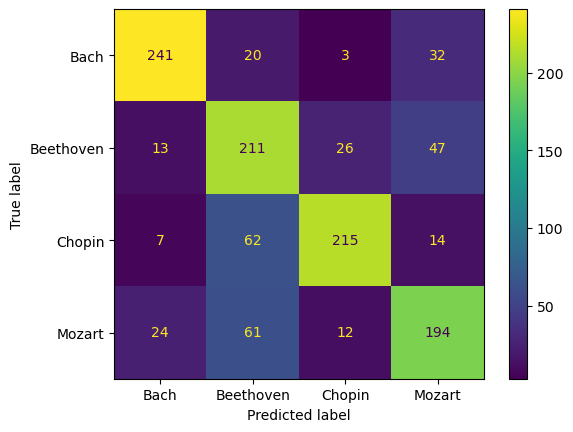

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

cnn_y_predict = CNN_baseline_model.predict(x_val) # predict on validation set
cnn_y_predicted_prob = np.argmax(cnn_y_predict, axis=1) # get the predicted class with the highest probability
cnn_y_actual = np.argmax(y_val, axis=1) # get the actual class 

print("Accuracy:", accuracy_score(cnn_y_actual, cnn_y_predicted_prob))
print(classification_report(cnn_y_actual, cnn_y_predicted_prob, target_names=label_encoder.classes_))
cm = confusion_matrix(cnn_y_actual, cnn_y_predicted_prob)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()

#### 2. Training and Validation Loss Plot, Accuracy and Validation Plot

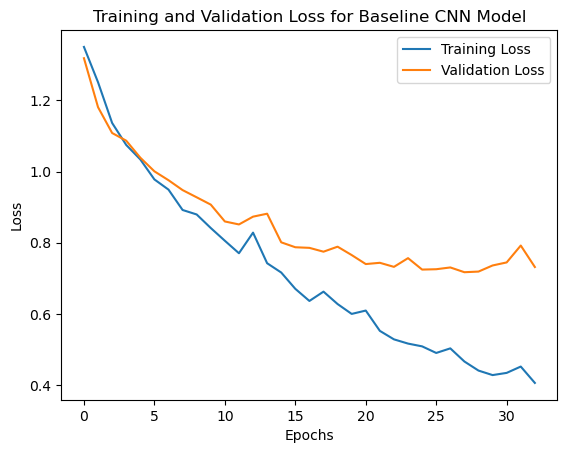

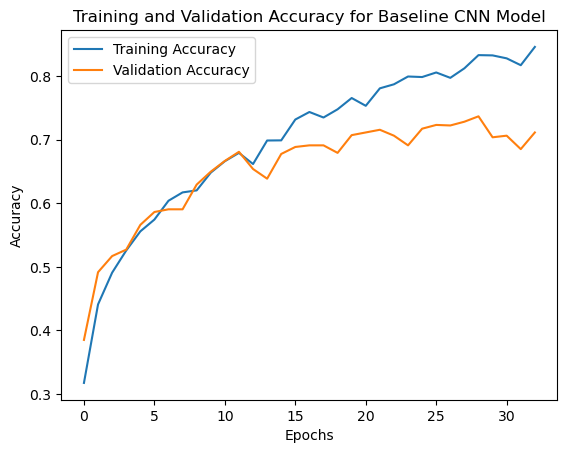

In [15]:
plt.plot(CNN_baseline_history.history['loss'], label='Training Loss')
plt.plot(CNN_baseline_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for Baseline CNN Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(CNN_baseline_history.history['accuracy'], label='Training Accuracy')
plt.plot(CNN_baseline_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Baseline CNN Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### 3. Model Optimization

For the optimized CNN, we started with the baseline setup of 0.3 dropout, 50 epochs, and batch size 32. This only reached around 35% accuracy, showing clear underfitting. We then increased dropout to 0.6, doubled the epochs to 100, and cut the batch size to 16. This change improved accuracy to 65% by giving the model more time to train with smaller, more focused batches. Next, we raised dropout to 0.9, but this dropped accuracy to 31% because the model was discarding too much information during training. We reverted dropout to 0.6 and set a very low learning rate of 0.000001. This significantly boosted accuracy to 78% as the small learning steps allowed for more stable convergence. We lowered dropout to 0.5 and increased the learning rate to 0.0003, with a minimum learning rate of 0.00001, which brought accuracy to 80%. Adding label smoothing of 0.05 slightly reduced performance to 77%, likely because it decreased the model’s confidence in its predictions. We lowered dropout again to 0.4, increased the epochs to 150, added kernel regularization, and extended early stopping patience from 8 to 12. This pushed accuracy up to 79%. Finally, we added new data augmentations to improve generalization. This resulted in the highest accuracy achieved, reaching 78.51%. This progression shows how tuning dropout, learning rate, and augmentation in small, targeted adjustments steadily improved the model’s performance.

#### 1. Build Optimized CNN model

In [16]:
# create reproducible results with random seeds
tf.random.set_seed(42) 
np.random.seed(42) 

CNN_optimized_model = Sequential([ # create model
    Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4), input_shape=x_train.shape[1:]), # 32 nuerons with 3x3 kernel, keep same padding
    BatchNormalization(), # to reduce overfitting
    MaxPooling2D((2, 2)), 
    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4), # dropout to reduce overfitting
    GlobalMaxPooling2D(), # global max pooling to reduce overfitting
    Dense(256, activation='relu', kernel_regularizer=l2(1e-4)),
    Dropout(0.4),
    Dense(len(target_composers), activation='softmax')
])

CNN_optimized_model.compile(
    optimizer= Adam(learning_rate=0.0003), # optimizer with a learning rate of 0.001 
    # loss=['categorical_crossentropy'], # loss function that does logistic regression to predict probabilities
     loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=['accuracy']
    )

early_stopping = EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True) # early stopping to prevent overfitting
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001) # reduce learning rate to prevent overfitting
model_checkpointer = ModelCheckpoint('cnn_best_weights.keras', monitor='val_loss', save_best_only=True) # save best model weights during training so that we can load them if needed

/opt/anaconda3/envs/env_tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### 2. Train Optimized Model

In [17]:
CNN_optimized_history = CNN_optimized_model.fit(x_train, y_train, epochs=150, batch_size=16, validation_data=(x_val, y_val), callbacks=[early_stopping, reduce_lr, model_checkpointer], verbose=0) # train model

#### 3. Evaluation

The optimized CNN clearly outperformed the baseline, reaching about 78.51% accuracy compared to the baseline’s 72.84%. The confusion matrix shows strong diagonal dominance, meaning the model is classifying most pieces correctly. Misclassifications are noticeably reduced for Beethoven and Mozart compared to the baseline. Looking at the training and validation loss curves, overfitting is much less severe. Validation loss levels out steadily after around 20 epochs, and the gap between training and validation loss stays small. The accuracy curves also show a smoother climb, with validation accuracy staying close to training accuracy throughout. Precision, recall, and F1-scores for all four composers are in the high 60s to high 80s, showing balanced performance across classes without one dominating or falling behind significantly. These gains come directly from the combination of regularization, adjusted dropout, kernel regularizer, and the extra data augmentations in the final setup.

37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Accuracy: 0.7851099830795262
              precision    recall  f1-score   support

        Bach       0.85      0.88      0.86       296
   Beethoven       0.69      0.69      0.69       297
      Chopin       0.83      0.88      0.85       298
      Mozart       0.77      0.69      0.73       291

    accuracy                           0.79      1182
   macro avg       0.78      0.78      0.78      1182
weighted avg       0.78      0.79      0.78      1182



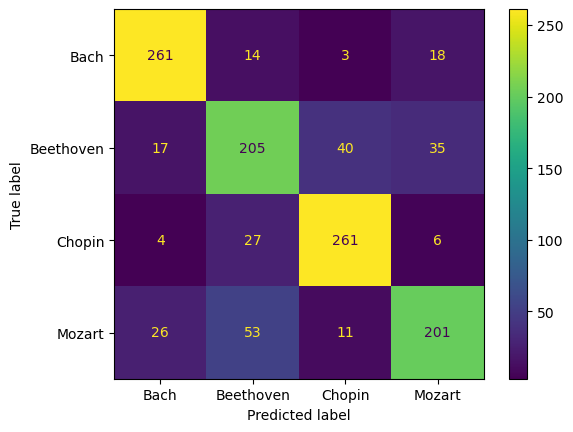

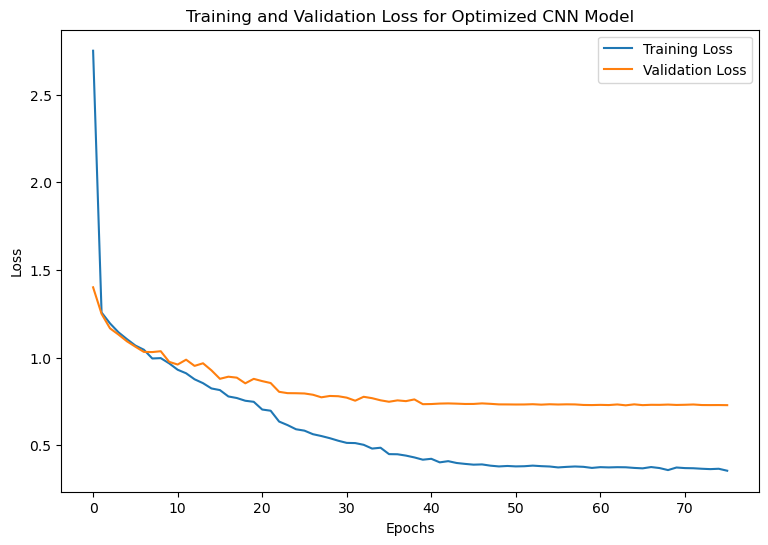

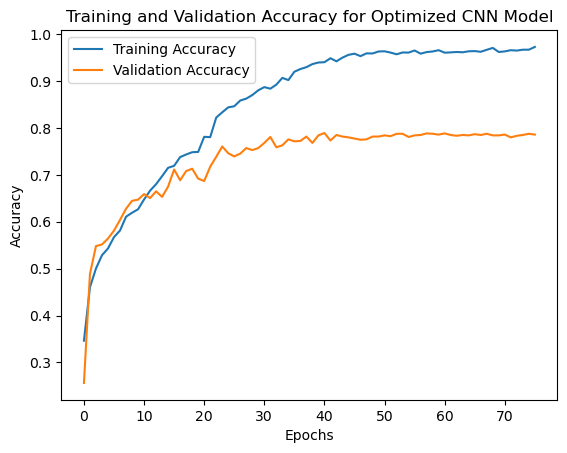

In [18]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

cnn_y_predict = CNN_optimized_model.predict(x_val) # predict on validation set
cnn_y_predicted_prob = np.argmax(cnn_y_predict, axis=1) # get the predicted class with the highest probability
cnn_y_actual = np.argmax(y_val, axis=1) # get the actual class 

print("Accuracy:", accuracy_score(cnn_y_actual, cnn_y_predicted_prob))
print(classification_report(cnn_y_actual, cnn_y_predicted_prob, target_names=label_encoder.classes_))
cm = confusion_matrix(cnn_y_actual, cnn_y_predicted_prob)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot()

plt.figure(figsize=(9, 6))
plt.plot(CNN_optimized_history.history['loss'], label='Training Loss')
plt.plot(CNN_optimized_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for Optimized CNN Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(CNN_optimized_history.history['accuracy'], label='Training Accuracy')
plt.plot(CNN_optimized_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy for Optimized CNN Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## II. CRNN - CNN + LSTM

### 1. Prepping and Splitting the Data for CRNN

CRNN (Convolutional Recurrent Neural Network) fuses two views of each piece:

Piano-roll branch (CNN → GRU): treats the piano roll like an image to learn local time–pitch patterns (chords, textures), then flattens across time for a GRU to capture longer temporal context.

Sequence branch (BiLSTM): processes the note-event sequence (pitch, duration, velocity, etc.) to capture event-level timing and phrasing.

Fusion layer: concatenates both embeddings and classifies the composer with a softmax.

In [19]:
# Prepare training, development, and test datasets
X_train_seq, X_train_roll, y_train_enc = prepare_data(TRAIN, NUM_CLASSES, 'Train')
X_dev_seq, X_dev_roll, y_dev_enc = prepare_data(DEV, NUM_CLASSES, 'Dev')
X_test_seq, X_test_roll, y_test_enc = prepare_data(TEST, NUM_CLASSES, 'Test')

/opt/anaconda3/envs/env_tf/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Train Roll: (5907, 128, 128, 1)
Train Seq: (5907, 500, 7)
Train Target: (5907, 4)


/opt/anaconda3/envs/env_tf/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Dev Roll: (47, 128, 128, 1)
Dev Seq: (47, 500, 7)
Dev Target: (47, 4)


/opt/anaconda3/envs/env_tf/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing archive/composers/test/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Error processing archive/composers/test/Beethoven/Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Test Roll: (51, 128, 128, 1)
Test Seq: (51, 500, 7)
Test Target: (51, 4)


### 1. Building the model

This architecture is a dual-branch Convolutional Recurrent Neural Network (CRNN) designed to combine the features from piano roll images and note sequence data for classifying the composers.

Overview
The model has two parallel input pipelines:

Piano Roll Branch (CNN → GRU) – Processes 128×128 grayscale piano roll representations to capture local spatial features (pitch–time patterns) using four convolutional blocks with L2 regularization, max pooling, and batch normalization. The extracted features are flattened along the time axis and passed through a GRU layer to model temporal dependencies in the note patterns.

Note Sequence Branch (BiLSTM) – Processes the note sequence of length MAX_SEQUENCE_LENGTH with 7 features per timestep using a bidirectional LSTM, followed by dense layers to capture melodic and rhythmic dependencies from both past and future contexts.

Feature Fusion & Classification
The outputs from both branches are concatenated, passed through two dense layers with ReLU activations and dropout for regularization, and finally projected into NUM_CLASSES with a softmax activation for multi-class classification.

Key Strengths

Combines the pixel level spatial features using CNN with temporal dependencies in note patterns using GRU and BiLSTM for richer bidirectional sequence learning.

To overcome overfitting, regularization is implemented. This can adapt to different input sizes and sequence lenghts.

In [20]:
# Build CRNN model for composer classification
def build_crnn_model():
    WEIGHT_DECAY = 1e-4  # L2 strength (aka weight decay)

    # Piano roll branch (CNN)
    roll_input = layers.Input(shape=(128, 128, 1), name="roll_input")

    # Block 1
    x = layers.Conv2D(8, (3, 3), activation='relu', padding='same',
                    kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(roll_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    # Block 2
    x = layers.Conv2D(16, (3, 3), activation='relu', padding='same',
                    kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    # Block 3
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                    kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.MaxPooling2D((1, 5))(x)
    x = layers.BatchNormalization()(x)

    # Block 4
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                    kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.BatchNormalization()(x)

    # Reshape -> GRU
    shape = x.shape  # (batch, t, p, c)
    x = layers.Reshape((shape[1] * shape[2], shape[3]))(x)

    # Add L2 on GRU kernel; optional on recurrent kernel too
    x = layers.GRU(64, return_sequences=False,
                kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
                recurrent_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    roll_features = layers.Dropout(0.5)(x)

    # Note sequence branch (BiLSTM)
    seq_input = layers.Input(shape=(MAX_SEQUENCE_LENGTH, 7), name="seq_input")

    y = layers.Bidirectional(
            layers.LSTM(128, return_sequences=False,
                        kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
                        recurrent_regularizer=regularizers.l2(WEIGHT_DECAY))
        )(seq_input)
    y = layers.BatchNormalization()(y)
    seq_features = layers.Dense(128, activation='relu',
                                kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(y)
    seq_features = layers.Dropout(0.5)(seq_features)

    # Fusion & classifier
    combined = layers.concatenate([roll_features, seq_features], name="fusion_layer")
    z = layers.Dense(128, activation='relu',
                    kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(combined)
    z = layers.Dropout(0.5)(z)
    z = layers.Dense(64, activation='relu',
                    kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(z)

    output = layers.Dense(NUM_CLASSES, activation='softmax',
                        kernel_regularizer=regularizers.l2(WEIGHT_DECAY),
                        name="output")(z)

    model = Model(inputs=[roll_input, seq_input], outputs=output, name="CRNN_PianoSeq_Fusion")
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    print(model.summary())
    return model


### 2. Train the model

In [21]:
model = build_crnn_model()

# Callback: Stop training early if validation loss doesn't improve for 5 consecutive epochs
# Restores the model weights from the epoch with the best validation loss
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

# Callback: Reduce learning rate if validation loss plateaus for 3 consecutive epochs
# Halves the learning rate each time, with a lower limit of 1e-6
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=3, 
    min_lr=1e-6
)

# Train the model using both piano roll and note sequence inputs
history = model.fit(
    [X_train_roll, X_train_seq],    # Training inputs: [CNN input, LSTM input]
    y_train_enc,                    # One-hot encoded target labels
    epochs=100,                     # Maximum number of training epochs
    batch_size=32,                  # Number of samples per gradient update
    validation_data=([X_dev_roll, X_dev_seq], y_dev_enc),  # Validation inputs, Validation labels
    callbacks=[early_stop, reduce_lr],  # Apply early stopping and LR scheduling
    verbose=1                           # Display progress during training
)

Model: "CRNN_PianoSeq_Fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ roll_input          │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 128, 128,  │         80 │ roll_input[0][0]  │
│                     │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 64, 8) │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64, 8) │         32 │ max_pooling2d_6[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 64, 64,    │      1,168 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 32,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ max_pooling2d_7[… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │      4,640 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 32, 6, 32) │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 6, 32) │        128 │ max_pooling2d_8[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 6, 64) │     18,496 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 16, 3, 64) │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_input           │ (None, 500, 7)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 3, 64) │        256 │ max_pooling2d_9[… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 256)       │    139,264 │ seq_input[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 48, 64)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ bidirectional[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 256,228 (1000.89 KB)

 Trainable params: 255,476 (997.95 KB)

 Non-trainable params: 752 (2.94 KB)

None
Epoch 1/100


/opt/anaconda3/envs/env_tf/lib/python3.10/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['roll_input', 'seq_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


185/185 ━━━━━━━━━━━━━━━━━━━━ 38s 161ms/step - accuracy: 0.4131 - loss: 1.3767 - val_accuracy: 0.3404 - val_loss: 1.4413 - learning_rate: 0.0010
Epoch 2/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.5532 - loss: 1.1043 - val_accuracy: 0.5745 - val_loss: 1.2279 - learning_rate: 0.0010
Epoch 3/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 143ms/step - accuracy: 0.6249 - loss: 0.9494 - val_accuracy: 0.7021 - val_loss: 0.8087 - learning_rate: 0.0010
Epoch 4/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 29s 156ms/step - accuracy: 0.6851 - loss: 0.8642 - val_accuracy: 0.7021 - val_loss: 0.8927 - learning_rate: 0.0010
Epoch 5/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.7182 - loss: 0.7650 - val_accuracy: 0.6596 - val_loss: 1.0352 - learning_rate: 0.0010
Epoch 6/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - accuracy: 0.7466 - loss: 0.7178 - val_accuracy: 0.6596 - val_loss: 1.1643 - learning_rate: 0.0010
Epoch 7/100
185/185 ━━━━━━━━━━━━━━━━━━━━ 27s 147ms/step - accuracy: 0.7748 -

### 3. Model Evaluation

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.7155 - loss: 0.7812
Test accuracy: 0.7451


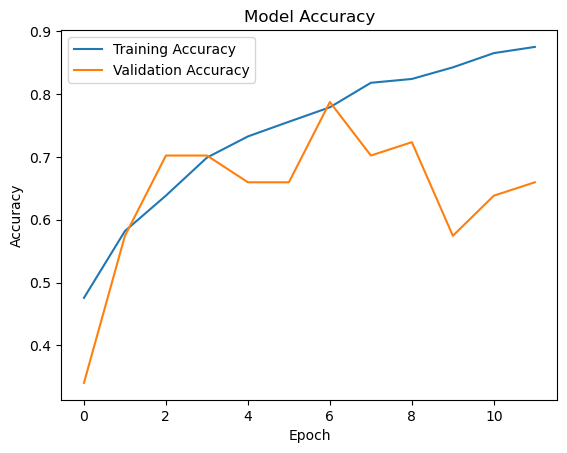

In [22]:
def predict_composer(model, history, X_test_roll, X_test_seq, y_test_enc):
    # Evaluation
    test_loss, test_acc = model.evaluate([X_test_roll, X_test_seq], y_test_enc, verbose=1)
    print(f"Test accuracy: {test_acc:.4f}")

    # Visualization
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Predict composer
predict_composer(model, history, X_test_roll, X_test_seq, y_test_enc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 439ms/step
Classification Report

              precision    recall  f1-score   support

        Bach     0.9231    0.9231    0.9231        13
   Beethoven     0.5882    0.7143    0.6452        14
      Chopin     0.7143    0.6667    0.6897        15
      Mozart     0.8571    0.6667    0.7500         9

    accuracy                         0.7451        51
   macro avg     0.7707    0.7427    0.7520        51
weighted avg     0.7581    0.7451    0.7476        51



<Figure size 640x480 with 0 Axes>

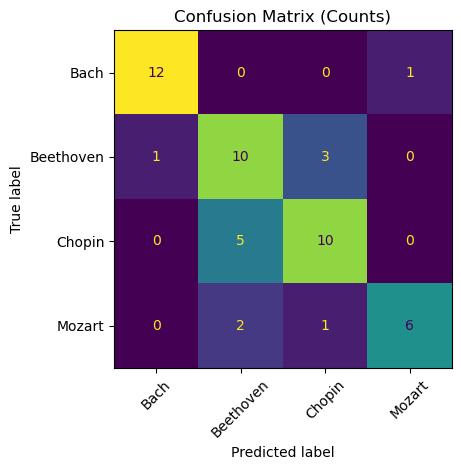

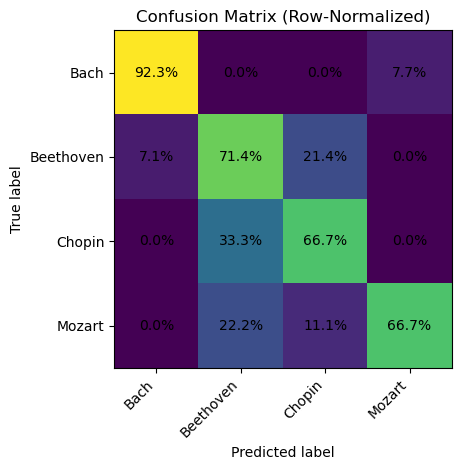

Sample 43: True=Bach | Top-3=[('Mozart', 0.6656432747840881), ('Bach', 0.2133588343858719), ('Beethoven', 0.11960877478122711)]
Sample 40: True=Bach | Top-3=[('Bach', 0.901522159576416), ('Mozart', 0.0724279060959816), ('Beethoven', 0.024406718090176582)]
Sample 46: True=Bach | Top-3=[('Bach', 0.9004852175712585), ('Mozart', 0.08095908910036087), ('Beethoven', 0.0177787896245718)]
Sample 12: True=Chopin | Top-3=[('Beethoven', 0.6228564977645874), ('Mozart', 0.22276434302330017), ('Bach', 0.09756070375442505)]
Sample 24: True=Beethoven | Top-3=[('Beethoven', 0.6867194175720215), ('Mozart', 0.29343950748443604), ('Bach', 0.011272603645920753)]


In [23]:
# Predict on the test set 
y_proba = model.predict([X_test_roll, X_test_seq])     # shape: (N, NUM_CLASSES)
y_pred  = np.argmax(y_proba, axis=1)                   # predicted class indices
y_true  = np.argmax(y_test_enc, axis=1)                # true class indices

# Print a classification report 
print("Classification Report\n")
print(classification_report(y_true, y_pred, target_names=target_composers, digits=4))

# Confusion matrix (counts) 
cm = confusion_matrix(y_true, y_pred, labels=range(len(target_composers)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_composers)

plt.figure()
disp.plot(values_format='d', xticks_rotation=45, colorbar=False)
plt.title("Confusion Matrix (Counts)")
plt.tight_layout()
plt.show()

# Confusion matrix 
cm_norm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)  # handle any divide-by-zero if a class has 0 support

fig, ax = plt.subplots()
im = ax.imshow(cm_norm, interpolation='nearest')  # default colormap
ax.set_title("Confusion Matrix (Row-Normalized)")
ax.set_xticks(np.arange(len(target_composers)))
ax.set_yticks(np.arange(len(target_composers)))
ax.set_xticklabels(target_composers, rotation=45, ha='right')
ax.set_yticklabels(target_composers)
ax.set_ylabel('True label')
ax.set_xlabel('Predicted label')

# Annotate cells with percentages
for i in range(cm_norm.shape[0]):
    for j in range(cm_norm.shape[1]):
        ax.text(j, i, f"{cm_norm[i, j]*100:.1f}%", ha="center", va="center")

fig.tight_layout()
plt.show()

# Top-3 predictions for a few samples
top_k = 3
sample_idxs = np.random.choice(len(y_true), size=min(5, len(y_true)), replace=False)
for idx in sample_idxs:
    probs = y_proba[idx]
    top_indices = probs.argsort()[-top_k:][::-1]
    tops = [(target_composers[i], float(probs[i])) for i in top_indices]
    print(f"Sample {idx}: True={target_composers[y_true[idx]]} | Top-{top_k}={tops}")


Accuracy: 74.51% – About three-quarters of the predictions match the true labels. 

Bach stands out with consistently high precision and recall, indicating that its features are well captured by the model.

Beethoven and Chopin are sometimes confused with each other, suggesting that the current features may not be sufficient to distinguish between them.

Mozart recall is moderate, while precision is good, the model fails to detect some Mozart pieces.

The weighted average is slightly lower than the macro average because the confusion in mid-performing classes (Beethoven, Chopin) affects the majority of predictions.

## III. LSTM - Independent work from Nathan 

___

In [37]:
# Import packages
import kagglehub
import pretty_midi
import numpy as np
import pandas as pd
from pathlib import Path

# Download dataset
path = kagglehub.dataset_download("blanderbuss/midi-classic-music")
data_directory = Path(path)

The code below declares the composers we care about. It defines a function to detect the composer of each .mid file by checking its folder and filename for keywords. Since the data is not formally labeled, we use weak labeling: matching file/ folder namers to known composer names. This lets us assign class labels( Mozart, Bach,..) to each MIDI file in the absence of metadata. These labels are our classification targets.

#### Data Preprocessing/ Feature Extraction & Augmentation

In [38]:
# Define target composers
target_composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

# This function automatically labels your MIDI files by extracting the composer's name from the file path or filename.
# Since your dataset doesn't have a CSV or manual labels, this function helps build those labels for training your LSTM or CNN model that classifies composers — in this case:
# Composer detection from folder or filename

def infer_composer_from_path(midi_path):
    folder = midi_path.parent.name.lower()
    # The line above gets the name of the folder the file is in
    filename = midi_path.name.lower()

    # Below, we're just looping through target composers & checks whether the current composer name appears in the filename which allows for more flexible matching
    # If a match is foudn, the function returns that composer's name as the label which is used to tag the MIDI file with its correct class
    for composer in target_composers:
        if composer.lower() in folder or composer.lower() in filename:
            return composer
    return None
     

In cell 2, above,

midi_path.parent gets the folder one level above the MIDI file.
.name extracts just the name of that folder (not the full path).
.lower() makes the folder name lowercase, so comparisons are case-insensitive.

In [39]:
# Feature extraction
# The code in the line below loads a MIDI file and extracts musical features from it to use as input data for the model and returns a dictionary
# of numerical values representing musical characteristics like pitch, duration, tempo, and note density
def extract_features(file_path):
    try:
      # Below, we're using pretyy_midi libary to load the data and converting the path into a string
      # That's going to parse all instruments, notes, tempos, etc.
        midi = pretty_midi.PrettyMIDI(str(file_path))
        # The code below is extracting note information.
        # The code allows the model to iterate through each instrument EXCEPT percussion(is_drum)
        # It extracts pitch, start times, durations, and velocities
        notes = []
        for instrument in midi.instruments:
            if not instrument.is_drum:
                for note in instrument.notes:
                    notes.append((note.pitch, note.start, note.end, note.velocity))
        if len(notes) < 5:
            return None

# DATA AUGMENTATION - The goal of augmentation is to increase the dataset diversity, improve model generalization, and simulate realistic musical variation without changing the actual label (composer)
# The Pitch shift is done becase musicians often switch the pitch of the melody of an entire song. The tune stays the same in terms of the relationship between the notes- the song just sounds lower or higher
# Velocity Jitter randomly scales note velocities(how "hard" each not is hit)
# A scale between 0.9 and 1.1 means that that version is 10% or louder than the original. This is common with performers.

            if augment:
            # Random pitch shift: -2 to +2 semitones
              pitch_shift = np.random.randint(-2, 3)  # shift by -2, -1, 0, 1, or 2
            # Velocity jitter: scale between 0.9 and 1.1
              velocity_scale = np.random.uniform(0.9, 1.1)

            notes = [
                (
                    min(max(n[0] + pitch_shift, 0), 127),  # keep pitch in MIDI range
                    n[1],
                    n[2],
                    int(min(max(n[3] * velocity_scale, 0), 127))  # scale velocity safely
                )
                for n in notes
            ]

# if len(notes) skips short or empty files that won't yield meaningful features then returns None so we can filter them out later
        pitches = [n[0] for n in notes]
        durations = [n[2] - n[1] for n in notes]
        velocities = [n[3] for n in notes]
        start_times = [n[1] for n in notes]

        # New features added
        # Below, we calculate the average, variation, and range of tempo and defaults to 120 if there isn't tempo data
        # note_density measures how dense the notes are over time(notes/second)- this is useful for distinguishing slow, more periodic compositions from fasters one's
        # with more notes/second

        tempo_changes = midi.get_tempo_changes()[1]
        tempo_mean = np.mean(tempo_changes) if len(tempo_changes) > 0 else 120
        tempo_std = np.std(tempo_changes) if len(tempo_changes) > 0 else 0
        tempo_range = np.max(tempo_changes) - np.min(tempo_changes) if len(tempo_changes) > 0 else 0
        note_density = len(notes) / (max(start_times) - min(start_times)) if max(start_times) != min(start_times) else 0


# Now below, I'm creating a feature vectior thar represents the most important features I've engineered
# Each MIDI file gets converted into a feature vector and each number in this list corresponds to a specific feature
# In ML and DL, you can't feed raw text or sound into a model directly- this standardizes input for the model and gives it a numerical representation
# Then the model learns patterns to classify or predict the composer

        return {
            'pitch_mean': np.mean(pitches),
            'pitch_std': np.std(pitches),
            'duration_mean': np.mean(durations),
            'duration_std': np.std(durations),
            'velocity_mean': np.mean(velocities),
            'velocity_std': np.std(velocities),
            'tempo_mean': tempo_mean,
            'tempo_std': tempo_std,
            'pitch_range': np.ptp(pitches),
            'duration_range': np.ptp(durations),
            'note_count': len(notes),
            'unique_pitch_count': len(set(pitches)),
            'unique_duration_count': len(set(durations)),
            'tempo_range': tempo_range,
            'note_density': note_density

        }
    except Exception as e:
        print(f"Failed on {file_path.name}: {e}") # Corrected to use file_path.name
        return None

Next, the data preparation pipeline. We will convert the raw, symbolic MIDI files -> into clean, structured data where each row is a musical piece and each column is a feature or label. This code:

Loops over all MIDI files
Filters for files that match the target variables
Applies feature extraction function
Stores each file's features and its composer into an master list
Converts the list into a pandas.DataFrame
Second,we will conduct some feature engineering. Instead of feeding raw note sequences into the model, we summarize each song's musical structure into a small set of numerical descriptors- similar to how a music theorist might describe a pitch as "low-pitched and long-duration." These statistical summaries act as a machine-readable fingerprints of each piece. This code:

Loads the MIDI file
Extracts note pitch and duration information
Computes simple statistical summaries for pitches and durations
Skips files that fail or have very few notes

#### Model Building

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# in the chunk of code below, we are recursively finding all the .mid files in the director- .rglob simply allows you to traverse nested folders
# Then we're only keeping files that have an identifiable composer label
all_midi_files = list(data_directory.rglob("*.mid"))
valid_files = [f for f in all_midi_files if infer_composer_from_path(f) is not None]

# infer Composer for each of the files
# The code below is a little redundant but it rechecks the inferred label in actually one of the target composers which accidnetally guards against stray file matches
valid_midi_files = []
for f in all_midi_files:
  if infer_composer_from_path(f) in target_composers:
    valid_midi_files.append(f)

# Now, to split the MIDI files BEFORE EXTRACTION- To avoid leakage!
# simply split 80% training & 20% testing and setting the seed for reproducibility
train_files, test_files = train_test_split(valid_midi_files, test_size=0.2, random_state=42)

# Extract features separately for each set
# Below, for each file I'm running the extract_features() function, attaching the corresponding composer label, and skipping files that failed or returned None
def extract_features_for_files(files):
    feats = []
    for f in files:
        composer = infer_composer_from_path(f)
        feat = extract_features(f)
        if feat and composer:
            feat['composer'] = composer
            feats.append(feat)
    return feats

# Code chunk below gives us two clean datasets, ready to convert to a structured format

train_features = extract_features_for_files(train_files)
test_features = extract_features_for_files(test_files)

# Convert to DataFrames
# Each column is a musical feature, with one column for the target label

df_train = pd.DataFrame(train_features)
df_test = pd.DataFrame(test_features)

# Encode Labels
# Code below converts string label like Bach into integers so the model can use it amnd the mapping is stored in label_encoder.classes_

label_encoder = LabelEncoder()
df_train['label'] = label_encoder.fit_transform(df_train['composer'])
df_test['label'] = label_encoder.transform(df_test['composer'])

# Split Data into training and test sets that are startified to preserve label balance
# Simply separating the features (x) & labels (y) for training/testing & removes the "composer" string column
X_train = df_train.drop(['composer', 'label'], axis=1).values
y_train = df_train['label'].values
X_test = df_test.drop(['composer', 'label'], axis=1).values
y_test = df_test['label'].values

# Normalize the features
# The standardizes the features so the mean = 0 & the standard deviation = 1.
# This is important because it prevents larger numeric ranges (like note_count) from overpowering others (like pitch_std)
# Fit on training data and transform test data using the same scaler to avoid leakage

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Preview Shapes
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print("Classes:", list(label_encoder.classes_))

/opt/anaconda3/envs/env_tf/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Failed on chopin7.mid: MThd not found. Probably not a MIDI file
Failed on Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
(420, 15) (105, 15) (420,) (105,)
Classes: ['Bach', 'Beethoven', 'Chopin', 'Mozart']


Above, we used LabelEncoder to convert composer names into numeric values so they can be used by the neural network. We split the data into a training and test set and use stratify = y to make sure each set contains an equal proportion of each composer.

In [41]:

df_train['composer'].value_counts()

composer
Bach         133
Chopin       112
Beethoven    111
Mozart        64
Name: count, dtype: int64

Further Preprocessing:

In [42]:
from sklearn.utils.class_weight import compute_class_weight

# Compute balanced class weights based on y_train
raw_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary: {0: weight_for_Bach, 1: weight_for_Beethoven, ...}
class_weights = dict(enumerate(raw_weights))

# Now, I'm going to try to apply softening
soft_class_weights = {cls: weight**0.75 for cls, weight in class_weights.items()}

To verify class weights and ensure the imbalance is taken care of:

In [43]:
for label, weight in class_weights.items():
    print(f"Class '{label_encoder.inverse_transform([label])[0]}' → weight: {weight:.2f}")

Class 'Bach' → weight: 0.79
Class 'Beethoven' → weight: 0.95
Class 'Chopin' → weight: 0.94
Class 'Mozart' → weight: 1.64


In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import Input

Now, to reshape the inputs for the LSTM model then build, compile, and train the model

#### Model Training

In [45]:
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Now, I'm reshaping the feature vectors to make them compatible with the LSTM model, which expects input in a specific 3D format
# LSTM models and all recurrent neural networks expect input in this shape: (batch_size, timesteps, features)
# We only want 1 timestep because we're treating the enture feature vector of each MIDI file as a single timestep
# We can change if we want true sequence data later
# We do this by switching to a note-level sequence model which would give the LSTM more temporal data to learn from

In [46]:
# Below, we are using a sequential deep learning model composed of 2 stacked LSTM layers, dropout and batch normalization, dense layers, and a final softmax classification
# I used Keras' sequential for a simple stacked model
# The first LSTM layer has 128 LSTM units with an input shape to match the reshaped input. return_sequences = true passes the full output sequence to the next LSTM which is required when stacking LSTMs
# using kernel_regularizer=l1(0.001) it discourages overfitting by penalizing larger weights

model = Sequential([
    Input(shape=(1, X_train_scaled.shape[1])), # Define Input layer here
    LSTM(128,
         return_sequences=True,  # Add this to output sequences
         kernel_regularizer= l2(0.001)),
    BatchNormalization(),
    Dropout(0.3),
# The dropout rate randomly zeroes 30% of connections during training to again prevent overfitting. BatchNormalization stabilizes training and speeds up convergence
    LSTM(64,
         kernel_regularizer= l2(0.001)), # Remove input_shape here
    BatchNormalization(),
    Dropout(0.3),
# Now, a dense hidden layer with 32 units and ReLU activation which adds non-linearity and learns higher level patters
    Dense(32, activation = 'relu',
          kernel_regularizer= l2(0.001)),
    BatchNormalization(),
# The final output layer uses softmax because we have multiple classes (4)
    Dense(len(label_encoder.classes_), activation = 'softmax')])

# Compile the Model
# Adam is great for most use cases as an optimizer and sparse_categorical_crossentropy is the correct choice for integer label
model.compile(optimizer = Adam(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

# Again, to prevent overfitting, I'm using early stopping which stops training if validation loss doesn't improve for 5 epochs
# It then restores the best model weights
early_stopping = EarlyStopping(monitor = 'val_loss',
                               patience = 5, restore_best_weights = True)
# Train the Model and include the new class weights
history = model.fit(X_train_lstm, y_train, validation_data = (X_test_lstm, y_test), epochs = 50, batch_size = 32, verbose = 1, callbacks=[early_stopping], class_weight = soft_class_weights)

Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - accuracy: 0.4348 - loss: 1.7333 - val_accuracy: 0.3524 - val_loss: 1.6065
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6122 - loss: 1.2815 - val_accuracy: 0.3524 - val_loss: 1.5922
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6327 - loss: 1.1858 - val_accuracy: 0.4381 - val_loss: 1.5820
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6388 - loss: 1.1946 - val_accuracy: 0.4190 - val_loss: 1.5743
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.7056 - loss: 0.9881 - val_accuracy: 0.4000 - val_loss: 1.5710
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7067 - loss: 1.0144 - val_accuracy: 0.3905 - val_loss: 1.5631
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7512 - loss: 0.9444 - val_accuracy: 0.3524 - val_loss: 1.5551
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6854 - loss: 0.9609 - val_accuracy: 0.3619 - v

In [47]:

print(label_encoder.classes_)
print(np.unique(y_train, return_counts=True))

['Bach' 'Beethoven' 'Chopin' 'Mozart']
(array([0, 1, 2, 3]), array([133, 111, 112,  64]))


In the code above, we are likely seeing early overfitting which is why the training accuracy keeps improving but the validation accuracy plateaus or worsens. This means our model is memorizing the training data, but not generalizing better

Considering this is just a rough draft, there are a lot of things I know right away that could likely improve model accuracy. This includes: engineering more features like Total Note Count, Tempo/BPM, instrument count, pitch ranges, and note density. I also plan to add another dense Layer and try batch normalization.

In the code above we are building a basic 3-later feedforward neural network:

First layer = 64 Neurons & ReLu activation function Droupout- prevents overfitting by randomly disabling 30% of the neurons Second Layer - 32 Neurons & ReLu activation function Output Layer: 4 neurons( one per composer) with softmax activation function to output probabilites

Finally, to evaluate the model

#### Model Evaluation

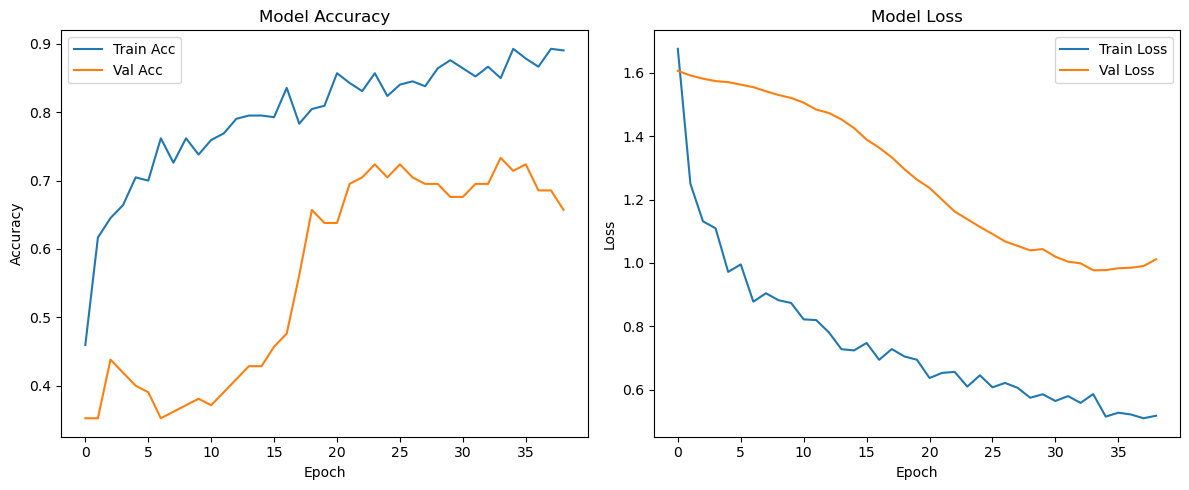

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step
 Classification Report:
              precision    recall  f1-score   support

        Bach       0.80      0.65      0.71        31
   Beethoven       0.60      0.71      0.65        21
      Chopin       0.85      0.88      0.86        25
      Mozart       0.69      0.71      0.70        28

    accuracy                           0.73       105
   macro avg       0.73      0.74      0.73       105
weighted avg       0.74      0.73      0.73       105



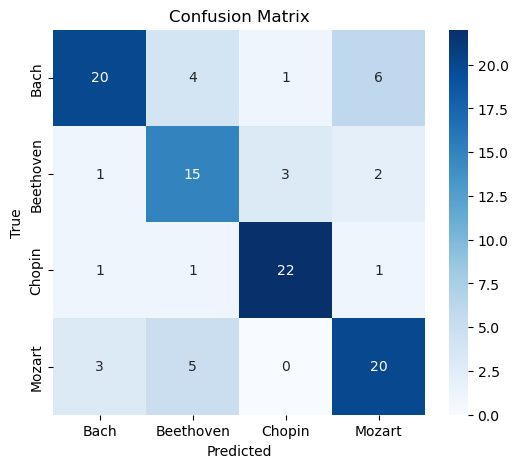

In [48]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Accuracy and loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Make predictions
y_pred = model.predict(X_test_lstm).argmax(axis=1)

# Print classification report
print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [49]:
from sklearn.metrics import accuracy_score

y_prediction_probabilities = model.predict(X_test_lstm)
y_prediction = np.argmax(y_prediction_probabilities, axis=1)

test_accuracy = accuracy_score(y_test, y_prediction)
print(f"Test Accuracy: {test_accuracy: .5f}")

print(classification_report(y_test, y_prediction, target_names=label_encoder.classes_))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy:  0.73333
              precision    recall  f1-score   support

        Bach       0.80      0.65      0.71        31
   Beethoven       0.60      0.71      0.65        21
      Chopin       0.85      0.88      0.86        25
      Mozart       0.69      0.71      0.70        28

    accuracy                           0.73       105
   macro avg       0.73      0.74      0.73       105
weighted avg       0.74      0.73      0.73       105



When compared to the old classification report, before apply data augmentations and balancing the class weights here is what I found:

Better macro & weighted averages- this shows the model performed better across all classes with the changes
Every class except Bach improved or stayed the same, meaning the model caifht more real Bach samples, even if it was slightly less precise.
Overall the new model is better. It's more accurate, has better average metrics, and shows stronger balanced predictions for 3/4 of the composers

___

# Project Summary, Findings and Future Improvements

For this project, we set out to classify MIDI files by composer (Bach, Beethoven, Chopin, and Mozart) using three different deep learning setups: a CNN, an LSTM, and a CRNN. 

Every MIDI file was converted into a fixed-size piano roll (128 pitches × 300 time frames × 1 channel), trimming or padding as needed so the inputs were consistent. The values were normalized to [0,1], labels were one-hot encoded, and the data was split into balanced training and validation sets. 

The CNN was used to pull out spatial features from pitch–time patterns, the LSTM focused on learning the sequential flow of notes, and the CRNN combined the two so we could model both spatial and temporal relationships at once. The baseline CNN landed at around 73% accuracy, and after several rounds of tuning, adding regularization, and augmenting the data, the optimized CNN reached about 78% accuracy with balanced performance across the four classes. 

The LSTM worked well for capturing temporal relationships but didn’t quite match the CNN in overall accuracy, likely because it struggled with the same level of spatial detail. 

The CRNN acted as a middle ground, performing better than the LSTM and close to the CNN while keeping stronger sequence awareness.  With an overall accuraacy of ~75%, Bach stands out with consistently high precision and recall, indicating that its features are well captured by the model. Beethoven and Chopin are sometimes confused with each other and Mozart recall is moderate, while precision is good

Across all models, Bach and Chopin were the easiest to identify, while Beethoven and Mozart were more often mixed up with each other. 

Data augmentation and parameter adjustments were key to getting better generalization and evening out performance across classes. 

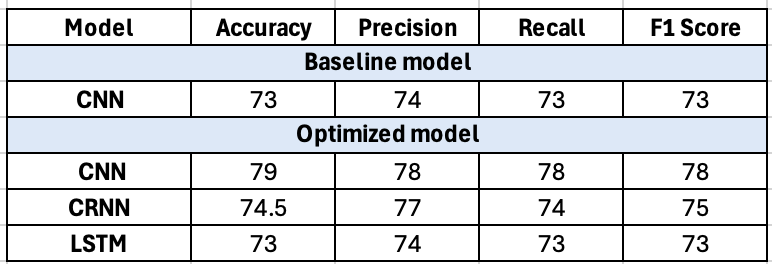




# Conclusions

Moving forward, the CRNN could be improved or tested with attention layers to boost long-term dependency learning, and adding more composers with a larger dataset would help reduce class confusion. It might also be worth experimenting with other feature representations, like spectrograms, harmonic fingerprints, or symbolic embeddings, to capture stylistic traits more effectively. Refining augmentation techniques to create realistic variations without distorting composer style, along with further hyperparameter tuning, could push the models even closer to perfect classification.

In addition, incorporating transfer learning from large, pre-trained audio or symbolic music models could help to enhance the accuracy, especially for underrepresented classes. Evaluating the architecture with different recurrent units such as Transformers or hybrid CNN–Transformer blocks also might help with performance gains.

### Contributers:
**Mohammad Alhabli:**
  * Building, Training and Optimizing CNN
  * Model Evaluation
  * Model Comparison
  * Project Summary, Findings and Future Improvements

**Karthik Vishwanath Raghavan**
  * Building, Training and Optimizing CRNN (Fusion of CNN + GRU + BiLSTM)
  * Data Collection and Libraries
  * Data Preprocessing & Data Augmentation
  * Conclusions

**Nathan Doss: Independent work**
  * Data collection & loading
  * Building, Training and Optimizing LSTM
  * Data Augmentation and Feature Selection
  * References, Citations and Frameworks used
  

# References, Citations and Frameworks used

Midi_classic_music. (n.d.). Retrieved August 11, 2025, from https://www.kaggle.com/datasets/blanderbuss/midi-classic-music

Kong, Q., Choi, K., & Wang, Y. (2020). Large-Scale MIDI-based Composer Classification (No. arXiv:2010.14805). arXiv. https://doi.org/10.48550/arXiv.2010.14805

Joshi, N. (2025). Using Machine Learning to Predict Classical Composers from Audio. Intersect: The Stanford Journal of Science, Technology, and Society, 18(2), Article 2. https://ojs.stanford.edu/ojs/index.php/intersect/article/view/2946

Fulford, K. (2022, November 8). Composer Style Classification Using Deep Learning. Composer Style Classification Using Deep Learning. https://medium.com/composer-style-classification-using-deep-learning/composer-style-classification-using-deep-learning-6bab64490995

Xie, X. (2024). A Hybrid CNN-LSTM Architecture for Enhanced Music Genre Classification. 2024 5th International Conference on Machine Learning and Computer Application (ICMLCA), 72–75. https://doi.org/10.1109/ICMLCA63499.2024.10753693
